# Sberbank House Price Regression

[Competition Link](https://www.kaggle.com/c/sberbank-russian-housing-market)

# Load Data and Basic Cleansing

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [20]:
# Load Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
macro = pd.read_csv('macro.csv')

Some extra cleansing procedures are required for data set. Next time, load cleaned data directly from path.

In [21]:
##Turn categorical variables into numeric values (No One-Hot-Encoding Yet)
col = list(test.columns)[2:]
for each in col:
    if train[each].dtype == 'object':
        train[each] = pd.factorize(train[each], sort=True)[0]
        test[each]=pd.factorize(test[each], sort=True)[0]

In [17]:
## For Macro: Remove special characters and Turn Them into numeric values.
for i in range(macro.shape[0]):
    for j in range(macro.shape[1]):
        try:
            macro.ix[i,j] = macro.ix[i,j].replace(',','')
        except Exception:
            pass
## Remove #! and Convert to Numeric Value
for each in list(macro.columns)[1:]:
    macro[each] = macro[each].replace('#!',None)
    macro[each] = list(np.array(macro[each]).astype(np.float))

In [18]:
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [22]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [ ]:
## Store the data
train.to_csv('train_c.csv',index=False)
test.to_csv('test_c.csv',index=False)
macro.to_csv('macro_c.csv',index=False)

Begin from this line.

In [3]:
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')
macro = pd.read_csv('macro_c.csv')

Define a function to put submission into df, and delete id column.

In [4]:
test_id = test['id']
def sub_result(prediction):
    result = pd.DataFrame({'id':test_id,'price_doc':prediction})
    return result

In [5]:
del test['id']
del train['id']

# Step 1: Fit xgboost to all variables in train-set

In [7]:
import xgboost as xgb
from ggplot import *
import matplotlib.pyplot as plt

**Purpose: See how far can we get if no data cleasing/feature engineering are applied. If result is satistified, generate feature importance**

What have done in Parameter Tuning: Adjust eta and max_depth respectively. Made several submissions with it.

In [8]:
col = list(test.columns)[1:]
label = train['price_doc']
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

In [67]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:8.2061e+06	test-rmse:8.21091e+06
[50]	train-rmse:2.5231e+06	test-rmse:2.91191e+06
[100]	train-rmse:2.18854e+06	test-rmse:2.73465e+06
[150]	train-rmse:2.07532e+06	test-rmse:2.70025e+06
[200]	train-rmse:1.98987e+06	test-rmse:2.68132e+06
[250]	train-rmse:1.91618e+06	test-rmse:2.66944e+06
[300]	train-rmse:1.85708e+06	test-rmse:2.66422e+06
[350]	train-rmse:1.80284e+06	test-rmse:2.65788e+06
Performance does not improve from 372 rounds


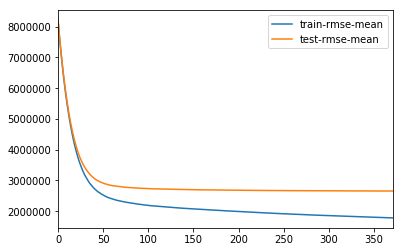

In [68]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

Then, fit all parameters in a model and get feature importance. For convenience, define a function that can export feature importance.

In [69]:
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [201]:
## Function for feature importance
def get_feature_importance(model):
    Importance = model.get_fscore()
    Importance = list(Importance.items())
    Feature= []
    Score = []
    for each in Importance:
        Feature.append(each[0])
        Score.append(each[1])
    df = pd.DataFrame({'Feature':Feature,'Score':Score}).sort_values(by=['Score'],ascending=[0])
    return df    

In [202]:
def plot_importance(model):
    FImportance = get_feature_importance(model).iloc[0:50,]
    plt.figure()
    FImportance.plot(kind='barh', x='Feature', y='Score', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.show()

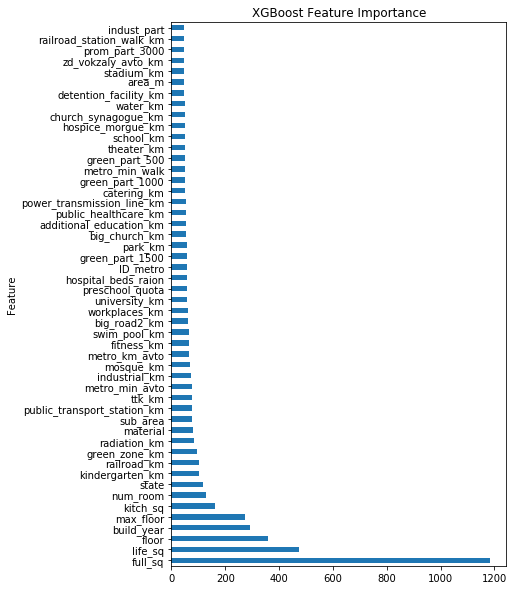

In [72]:
plot_importance(model)

Save feature importance.

In [73]:
FScore = get_feature_importance(model)
FScore.to_csv('FScore_xgb.csv',index=False)

In [66]:
## Make prediction and submit it
prediction = model.predict(dtest)
subm = sub_result(prediction)
subm.to_csv('Submission_as.csv',index=False)

**Public LB:0.31323, 168/2200**

In [74]:
## Keep Submission file name and PLB Score in two lists.
filename = ['Submission_as.csv']
LbCV = ['0.31323/2.65788']
Model=['xgb/depth5/eta0.05/NoFE']

# Step 2: Cleaning both datasets

**To improve the performance of the model, some feature engineering are required. With the feature importance of basic model, we first do EDA on important features selected by model.**

**Q:Log-labelled performed better than original label?**

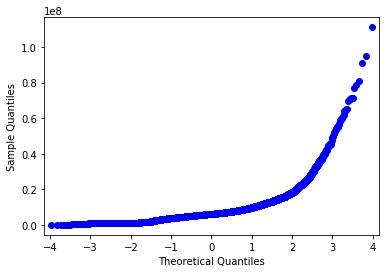

In [76]:
import statsmodels.api as sm
fig1 = sm.qqplot(train['price_doc'])
plt.show(fig1)
## Werid warning show up if use 'label'

**Detached from diagnose. Distribution supposed to be skewed. Try Log-transform**

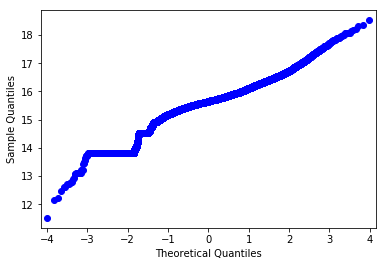

In [78]:
fig2 = sm.qqplot(np.log(train['price_doc']))
plt.show(fig2)

**Looks better than the previous one.**

**Test it.**

In [106]:
train['log_price']=np.log(train['price_doc'])
dtrain = xgb.DMatrix(train[col],train['log_price'])
dtest = xgb.DMatrix(test[col])

In [113]:
params = {
    'eta': 0.03, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:14.6685	test-rmse:14.6685
[50]	train-rmse:3.23684	test-rmse:3.23772
[100]	train-rmse:0.835923	test-rmse:0.846636
[150]	train-rmse:0.466019	test-rmse:0.493593
[200]	train-rmse:0.429404	test-rmse:0.466865
[250]	train-rmse:0.418613	test-rmse:0.464118
[300]	train-rmse:0.410926	test-rmse:0.463205
[350]	train-rmse:0.403715	test-rmse:0.462678
[400]	train-rmse:0.396942	test-rmse:0.462514
Performance does not improve from 387 rounds


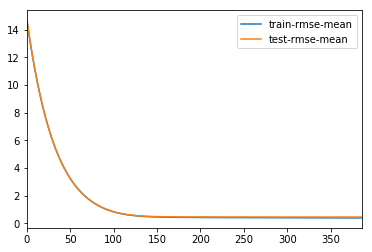

In [114]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [115]:
model1 = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [118]:
## Make prediction and submit it
prediction = model1.predict(dtest)
Prediction = np.exp(prediction)
subm = sub_result(Prediction)
subm.to_csv('Submission_loglabel.csv',index=False)

**Public LB 0.32680**

In [120]:
Model.append('xgboost/depth5/eta0.03/LogLabel')
filename.append('Submission_loglabel.csv')
LbCV.append('0.3268')

**Q: Will abnormal values heavily influence model performance?**

/home/jiashen/env3/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


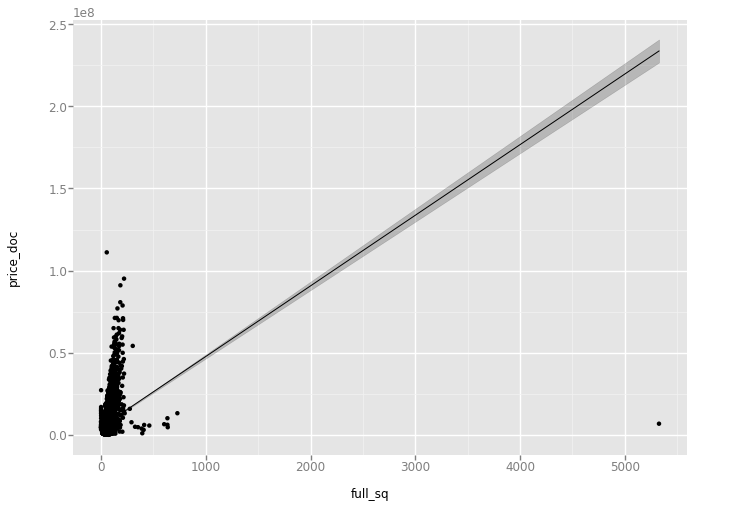

<ggplot: (-9223363245834845815)>


In [9]:
g = ggplot(train,aes(x='full_sq',y='price_doc'))+geom_point()+stat_smooth()
print(g)

In [10]:
corr_pr_sq = np.corrcoef(train['full_sq'],train['price_doc'])[0][1]
print('Correlation between full_sq&price_doc: '+str(corr_pr_sq))

Correlation between full_sq&price_doc: 0.341840459754


There is one point with quite high leverage! I guess: this is a **wrong data point**. Big house, cheap price.

In [11]:
max_full_sq = max(train['full_sq'])
max_full_sq_data = train[train['full_sq']==max_full_sq]
max_full_sq_data

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
3527,2012-09-07,5326,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,7,2,0,5,16,0,2,43,6,6868818


Simply remove it, let's check Pearson correlation and plot.

/home/jiashen/env3/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


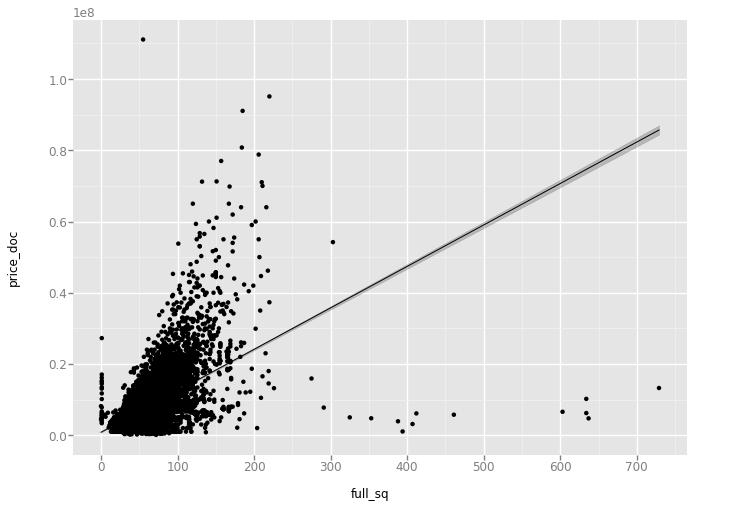

<ggplot: (8791010940189)>
Correlation between full_sq&price_doc: 0.562855069091


In [103]:
tmp_train = train[train['full_sq']<max_full_sq]
g = ggplot(tmp_train,aes(x='full_sq',y='price_doc'))+geom_point()+stat_smooth()
print(g)
corr_pr_sq_ = np.corrcoef(tmp_train['full_sq'],tmp_train['price_doc'])[0][1]
print('Correlation between full_sq&price_doc: '+str(corr_pr_sq_))

**Try SQRT Transformation on full_sq**

/home/jiashen/env3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jiashen/env3/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


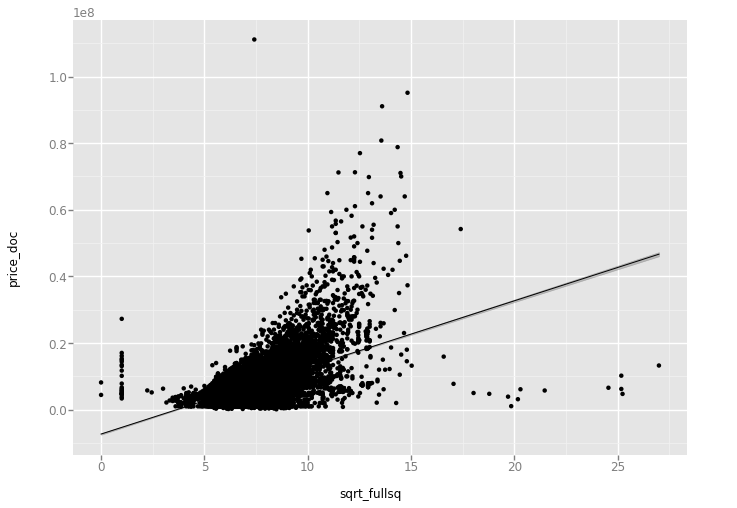

<ggplot: (-9223363245844501297)>
Correlation between squared full_sq&price_doc: 0.570149005339


In [13]:
## SQRT Fullsq
tmp_train['sqrt_fullsq'] = np.sqrt(tmp_train['full_sq'])
g = ggplot(tmp_train,aes(x='sqrt_fullsq',y='price_doc'))+geom_point()+stat_smooth()
print(g)
corr_pr_sq_ = np.corrcoef(tmp_train['sqrt_fullsq'],tmp_train['price_doc'])[0][1]
print('Correlation between squared full_sq&price_doc: '+str(corr_pr_sq_))

**Improvement is not that obvious.**

**How about those super-small house?**

In [22]:
small_house = tmp_train[tmp_train['full_sq']<5]
print(small_house.shape)

(26, 292)


So, what we can see is: a: Sometime the house is ridiculously small, but maybe this is not a problem. But some time, we got life sq way larger than the full_sq, this means we got some data problem in between, and full_sq and life_sq are two that are most important on predicting the house price. So, we need to deal with them. Let's first check life_sq, and deal with those data together.

**Life-sq vs price-doc**

/home/jiashen/env3/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


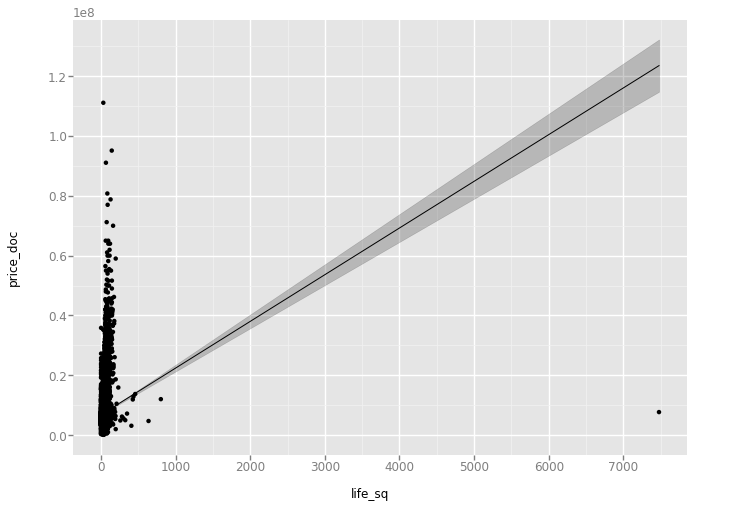

<ggplot: (-9223363245846770940)>
Correlation between price and life sq is 0.165605969193


In [32]:
non_nan_ls = train[train['life_sq'].notnull()]
g = ggplot(non_nan_ls,aes(x='life_sq',y='price_doc'))+geom_point()+stat_smooth()
print(g)
cor_life_price = np.corrcoef(non_nan_ls['price_doc'],non_nan_ls['life_sq'])[0][1]
print('Correlation between price and life sq is '+str(cor_life_price))

**OMG....This does not make any sense.**

**This may be a influential outlier. If we remove it, and check the correlation**

/home/jiashen/env3/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


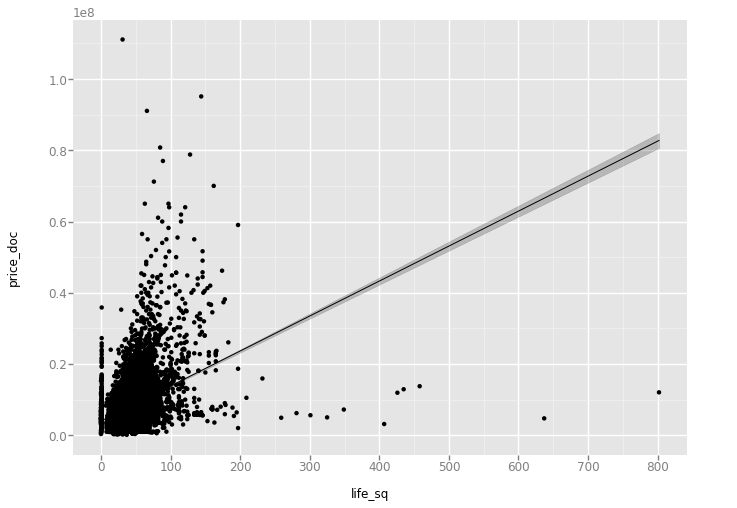

<ggplot: (-9223363245846193983)>
Correlation between price and life sq is 0.414844860644


In [35]:
non_nan_ls=non_nan_ls[non_nan_ls['life_sq']<max(non_nan_ls['life_sq'])]
g = ggplot(non_nan_ls,aes(x='life_sq',y='price_doc'))+geom_point()+stat_smooth()
print(g)
cor_life_price = np.corrcoef(non_nan_ls['price_doc'],non_nan_ls['life_sq'])[0][1]
print('Correlation between price and life sq is '+str(cor_life_price))

This looks way better.

**Deal with abnormal SQ-data.**

We found that, beside the property that has missing data of life-sq (which is a great predictor), we also got many cases that show a property having life-sq larger than full-sq. This seems to be not quite reasonable. Also, some property has super-small sq. We need to check them for making the data more neat.

In [37]:
house_smaller_lsq = tmp_train.query('full_sq<life_sq')
house_smaller_lsq.shape

(37, 292)

**So, what we are gonna do, is to: compare the life sq and full sq. Check the gap between them and fill in with the one that looks normal, in both train and test sets.**

**Build year check**

**Another important feature that we can see, is the build-year. Age of property does matter, but still, we got many outliers in the column. Let's have a look.**

In [61]:
buildyr_nonull = train[train['build_year'].notnull()]
buildyr_nonull.shape

(16866, 291)

In [69]:
maxyear=max(buildyr_nonull['build_year'])
print(maxyear)
buildyr_nonull[buildyr_nonull['build_year']<1000].shape

20052009.0


(903, 291)

**We got many abnormal cases on 'build_year'. To prevent them impacting model's performance, we turn them into 'nan' and let xgboost model handle them** 

**Floor and max_floor**

In [85]:
no_floor = tmp_train[tmp_train.floor.isnull()]
print(no_floor.shape)

(167, 292)


**Seems, data without floor is the independent house rather than apartment.**

In [87]:
no_floor['max_floor'].unique()

array([ nan])

We will try to create a new feature here: whether this property is an independent house or not!

In [88]:
with_floor = tmp_train[tmp_train.floor.notnull()]

In [91]:
print('Average price apartment '+str(np.mean(with_floor['price_doc'])))
print('Average price house: '+str(np.mean(no_floor['price_doc'])))
print(max(no_floor['price_doc']))
print(max(with_floor['price_doc']))

Average price apartment 7129860.97885
Average price house: 5885999.32934
33364718
111111112


In [92]:
print('Average sq apartment '+str(np.mean(with_floor['full_sq'])))
print('Average sq house: '+str(np.mean(no_floor['full_sq'])))
print(max(no_floor['full_sq']))
print(max(with_floor['full_sq']))

Average sq apartment 53.979044979
Average sq house: 65.3293413174
159
729


**Creating an additional variable may be beneficial for tree model.**

In [104]:
strange_floor = tmp_train.query('floor<max_floor')

In [109]:
strange_floor.shape

(16927, 291)

In [110]:
np.mean(strange_floor['price_doc'])

7449912.0154782301

Both quantity and impact seems to be big. We will involve another feature here.

In [115]:
tt=train[train['full_sq']>20]

**Summarize above analysis and prepare the updated training and testing data set. Then test them!**

In [173]:
## Re_load data set!
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')
del train['id']
del test['id']

In [160]:
train.shape

(30471, 291)

In [162]:
## Clean two super-large sq data
train = train[train['full_sq']<max_full_sq]
train=train[train['life_sq']!=max(non_nan_ls['life_sq'])]
train.shape

(30469, 291)

In [174]:
## Adjust abnormal full/life sq
for i in range(train.shape[0]):
    if train.iloc[i,1]<train.iloc[i,2] and np.isnan(train.iloc[i,2])!=True:
        if train.iloc[i,1]<10:
            train.iloc[i,1]=train.iloc[i,2]*1.2 ## Mannually set
        else:
            train.iloc[i,2]=train.iloc[i,1]*0.8

In [179]:
## Adjust abnormal build_year
for i in range(train.shape[0]):
    if train.iloc[i,6]>2017 or train.iloc[i,6]<1000:
        train.iloc[i,6]=np.nan

In [181]:
## Create New Feature: isApartment
isApa = [1 if np.isnan(each) else 0 for each in train['floor']]
train['isApa'] = isApa

In [183]:
## Clean Test Data
for i in range(test.shape[0]):
    if test.iloc[i,1]<test.iloc[i,2] and np.isnan(test.iloc[i,2])!=True:
        if test.iloc[i,1]<10:
            test.iloc[i,1]=test.iloc[i,2]*1.2 ## Mannually set
        else:
            test.iloc[i,2]=test.iloc[i,1]*0.8

In [188]:
## Adjust abnormal build_year
for i in range(test.shape[0]):
    if test.iloc[i,6]>2017 or test.iloc[i,6]<1000:
        test.iloc[i,6]=np.nan

In [190]:
## Create New Feature: isApartment
isApa = [1 if np.isnan(each) else 0 for each in test['floor']]
test['isApa'] = isApa

**Fit everything in a model and see the effectiveness of cleansing**

In [222]:
col = list(test.columns)[1:]

In [223]:
dtrain = xgb.DMatrix(train[col],train['price_doc'])
dtest = xgb.DMatrix(test[col])

In [207]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:8.20591e+06	test-rmse:8.2108e+06
[50]	train-rmse:2.5078e+06	test-rmse:2.91419e+06
[100]	train-rmse:2.18316e+06	test-rmse:2.7278e+06
[150]	train-rmse:2.06351e+06	test-rmse:2.68907e+06
[200]	train-rmse:1.98528e+06	test-rmse:2.67156e+06
[250]	train-rmse:1.91685e+06	test-rmse:2.66105e+06
Performance does not improve from 252 rounds


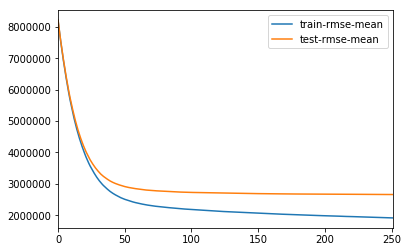

In [208]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=7)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [209]:
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [210]:
prediction=model.predict(dtest)

In [211]:
submission = sub_result(prediction)
submission.to_csv('Submission_clean_both2.csv',index=False)

**Seems only do data cleansing cannot push the model to the state-of-art**

**Q: How about: Adding timestamp in training and testing data-set?**

In [213]:
train['year']= train['timestamp'].apply(lambda x:int(x.split('-')[0]))
train['month']=train['timestamp'].apply(lambda x:int(x.split('-')[1]))
train['day']=train['timestamp'].apply(lambda x:int(x.split('-')[2]))

In [219]:
test['year']= test['timestamp'].apply(lambda x:int(x.split('-')[0]))
test['month']=test['timestamp'].apply(lambda x:int(x.split('-')[1]))
test['day']=test['timestamp'].apply(lambda x:int(x.split('-')[2]))

In [230]:
col = list(test.columns)[1:]
dtrain = xgb.DMatrix(train[col],train['price_doc'])
dtest = xgb.DMatrix(test[col])
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:8.20585e+06	test-rmse:8.21045e+06
[50]	train-rmse:2.51506e+06	test-rmse:2.90966e+06
[100]	train-rmse:2.17932e+06	test-rmse:2.72761e+06
[150]	train-rmse:2.05433e+06	test-rmse:2.68392e+06
[200]	train-rmse:1.96048e+06	test-rmse:2.66451e+06
[250]	train-rmse:1.88458e+06	test-rmse:2.65193e+06
[300]	train-rmse:1.82029e+06	test-rmse:2.64288e+06
[350]	train-rmse:1.76446e+06	test-rmse:2.63708e+06
[400]	train-rmse:1.7122e+06	test-rmse:2.63512e+06
Performance does not improve from 416 rounds


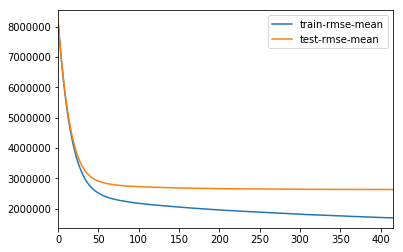

In [231]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [232]:
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [234]:
prediction = model.predict(dtest)

In [236]:
submission = sub_result(prediction)
submission.to_csv('Submission_YMD+Cleansing.csv',index=False)